<a href="https://colab.research.google.com/github/phamminh1998/GBM_Frontier_Market/blob/main/thesis_simulation_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


# 1. Estimate parameter

In [ ]:
import pandas as pd

# Load the data
data_path = '/gdrive/My Drive/BISS/EMTH0009 - Master Thesis/Data/hose_df_2022.csv'
hose_df_2022 = pd.read_csv(data_path)

# Convert 'date' column to datetime format
hose_df_2022['date'] = pd.to_datetime(hose_df_2022['date'])

# Sort the dataframe by ticker and date
hose_df_2022.sort_values(['ticker', 'date'], inplace=True)


# Display the first few rows of the dataframe
print(hose_df_2022.head())

# Display basic information about the dataframe
print(hose_df_2022.info())

          date ticker   open   high    low  close   volume
248 2022-01-04    ACB  34.80  34.80  34.25  34.40  5403400
247 2022-01-05    ACB  34.35  34.35  33.65  33.70  6839700
246 2022-01-06    ACB  33.50  34.00  33.10  33.75  7482700
245 2022-01-07    ACB  33.90  33.95  33.30  33.30  9895200
244 2022-01-10    ACB  33.00  33.40  32.95  33.00  9460100
<class 'pandas.core.frame.DataFrame'>
Index: 7968 entries, 248 to 7221
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    7968 non-null   datetime64[ns]
 1   ticker  7968 non-null   object        
 2   open    7968 non-null   float64       
 3   high    7968 non-null   float64       
 4   low     7968 non-null   float64       
 5   close   7968 non-null   float64       
 6   volume  7968 non-null   int64         
dtypes: datetime64[ns](1), float64(4), int64(1), object(1)
memory usage: 498.0+ KB
None


In [ ]:
  # Calculate daily returns for each ticker
hose_df_2022['daily_return'] = hose_df_2022.groupby('ticker')['close'].pct_change()

# Calculate the drift (µ) for each ticker base on last full year
drift = hose_df_2022.groupby('ticker')['daily_return'].mean()
drift = drift.rename('drift')
print(drift)

# Calculate the square of the differences between each daily return and the mean return
hose_df_2022['return_diff_sq'] = (hose_df_2022['daily_return'] - hose_df_2022.groupby('ticker')['daily_return'].transform('mean'))**2

# Calculate the volatility (σ) for each ticker
volatility = hose_df_2022.groupby('ticker')['return_diff_sq'].mean() ** 0.5
volatility = volatility.rename('volatility')
print(volatility)
print(volatility.info())

ticker
ACB         -0.001496
BCM          0.001225
BID          0.000514
BVH         -0.000471
CTG         -0.000606
FPT         -0.000458
GAS          0.000340
GVR         -0.003464
HDB         -0.002381
HPG         -0.003251
MBB         -0.001734
MSN         -0.001971
MWG         -0.003669
NVL         -0.007069
PDR         -0.007203
PLX         -0.001988
POW         -0.001787
SAB          0.000403
SSI         -0.003808
STB         -0.000899
TCB         -0.002373
TPB         -0.002524
VCB          0.000227
VHM         -0.002092
VIB         -0.003114
VIC         -0.002330
VJC         -0.000428
VN30INDEX   -0.001628
VNINDEX     -0.001550
VNM         -0.000372
VPB         -0.002213
VRE         -0.000269
Name: drift, dtype: float64
ticker
ACB          0.025008
BCM          0.028542
BID          0.027779
BVH          0.025752
CTG          0.027308
FPT          0.025047
GAS          0.026646
GVR          0.033587
HDB          0.024419
HPG          0.033595
MBB          0.028247
MSN         

# 2. GBM simulator

In [ ]:
import pandas as pd

# Load the data
data_path = '/gdrive/My Drive/BISS/EMTH0009 - Master Thesis/Data/hose_df_2023.csv'
hose_df_2023 = pd.read_csv(data_path)

# Convert 'date' column to datetime format
hose_df_2023['date'] = pd.to_datetime(hose_df_2023['date'])

# Sort the dataframe by ticker and date
hose_df_2023.sort_values(['ticker', 'date'], inplace=True)

#inspect dataframe
print(hose_df_2023)
print(hose_df_2023.info())

           date ticker   open   high    low  close   volume
248  2023-01-03    ACB  22.00  22.70  21.95  22.70  1547700
247  2023-01-04    ACB  22.85  22.85  22.55  22.65  7244400
246  2023-01-05    ACB  22.75  23.00  22.65  22.85  2104500
245  2023-01-06    ACB  22.80  23.35  22.60  23.15  8403100
244  2023-01-09    ACB  23.35  23.35  22.95  23.10  2491075
...         ...    ...    ...    ...    ...    ...      ...
7225 2023-12-25    VRE  22.85  23.40  22.85  23.40  3490400
7224 2023-12-26    VRE  23.35  23.50  23.15  23.30  2651000
7223 2023-12-27    VRE  23.30  23.45  23.20  23.25  3220300
7222 2023-12-28    VRE  23.25  23.70  23.25  23.50  6285000
7221 2023-12-29    VRE  23.65  23.65  23.30  23.30  4609200

[7968 rows x 7 columns]
<class 'pandas.core.frame.DataFrame'>
Index: 7968 entries, 248 to 7221
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    7968 non-null   datetime64[ns]
 1   ticker  7968 no

In [ ]:
# Set seed for random number generators
import random
import numpy as np

import os
import pandas as pd

class GeometricBrownianMotionAssetSimulator:
    """
    This callable class will generate a daily
    close price based DataFrame to simulate
    asset pricing paths with Geometric Brownian Motion (GBM) for pricing.

    It will output the results to a CSV with the ticker symbol.

    Parameters
    ----------
    start_date : `str`
        The starting date in YYYY-MM-DD format.
    end_date : `str`
        The ending date in YYYY-MM-DD format.
    output_dir : `str`
        The full path to the output directory for the CSV.
    symbol : `str`
        The ticker symbol to use.
    init_price : `float`
        The initial price of the asset.
    mu : `float`
        The mean 'drift' of the asset.
    sigma : `float`
        The 'volatility' of the asset.
    num_sims : `int`
        Number of GBM paths to simulate.
    """

    def __init__(
        self,
        start_date,
        end_date,
        output_dir,
        symbol,
        init_price,
        mu,
        sigma,
        num_sims
    ):
        self.start_date = start_date
        self.end_date = end_date
        self.output_dir = output_dir
        self.symbol = symbol
        self.init_price = init_price
        self.mu = mu
        self.sigma = sigma
        self.num_sims = num_sims

    def _create_empty_frame(self):
        """
        Creates the empty Pandas DataFrame with a date column using
        business days between two dates. Each of the price columns
        are set to zero.

        Returns
        -------
        `pd.DataFrame`
            The empty close price DataFrame for subsequent population.
        """
        date_range = pd.date_range(
            self.start_date,
            self.end_date,
            freq='B'
        )

        return pd.DataFrame(
            {
                'date': date_range,
                **{f'path_{i}': np.nan for i in range(1, self.num_sims + 1)}
            }
        )

    def _create_geometric_brownian_motion(self, data):
        """
        Calculates asset price paths using the analytical solution
        to the Geometric Brownian Motion stochastic differential
        equation (SDE).

        Parameters
        ----------
        data : `pd.DataFrame`
            The DataFrame needed to calculate length of the time series.

        Returns
        -------
        `pd.DataFrame`
            The DataFrame containing the asset price paths.
        """
        n = len(data)
        T = n / len(data['date'])
        dt = T / n

        paths = pd.DataFrame(
            self.init_price * np.exp(
                np.cumsum((self.mu - 0.5 * self.sigma ** 2) * dt + self.sigma * np.sqrt(dt) * np.random.normal(0, 1, size=(n, self.num_sims)), axis=0)
            ),
            columns=[f'path_{i}' for i in range(1, self.num_sims + 1)]
        )
        paths['average'] = paths.mean(axis=1)
        return pd.concat([data[['date']], paths], axis=1)

    def _output_frame_to_dir(self, data):
        """
        Output the fully-populated DataFrame to disk into the
        desired output directory.

        Parameters
        ----------
        data : `pd.DataFrame`
            The DataFrame containing the generated price paths.
        """
        output_file = os.path.join(self.output_dir, f'{self.symbol}.csv')
        data.to_csv(output_file, index=False)

    def __call__(self):
        """
        The entrypoint for generating the asset price frame. Firstly, this
        generates an empty frame. It then populates this
        frame with some simulated GBM data and saves it to disk as a CSV.
        """
        data = self._create_empty_frame()
        paths = self._create_geometric_brownian_motion(data)
        self._output_frame_to_dir(paths)


In [ ]:

# Get unique tickers
tickers = hose_df_2023['ticker'].unique()

# Create GBM paths for each ticker
output_dir = '/gdrive/My Drive/BISS/EMTH0009 - Master Thesis/Data/GBM_paths'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Run the simulation for each ticker
random.seed(12345)
np.random.seed(12345)

for ticker in tickers:
    ticker_data = hose_df_2023[hose_df_2023['ticker'] == ticker]
    start_date = ticker_data['date'].min()
    end_date = ticker_data['date'].max()
    init_price = ticker_data[ticker_data['date'] == start_date]['open'].iloc[0]
    mu = drift.loc[ticker]
    sigma = volatility.loc[ticker]

    gbm_simulator = GeometricBrownianMotionAssetSimulator(
        start_date,
        end_date,
        output_dir,
        ticker,
        init_price,
        mu,
        sigma,
        num_sims = 5000
    )

    gbm_simulator()


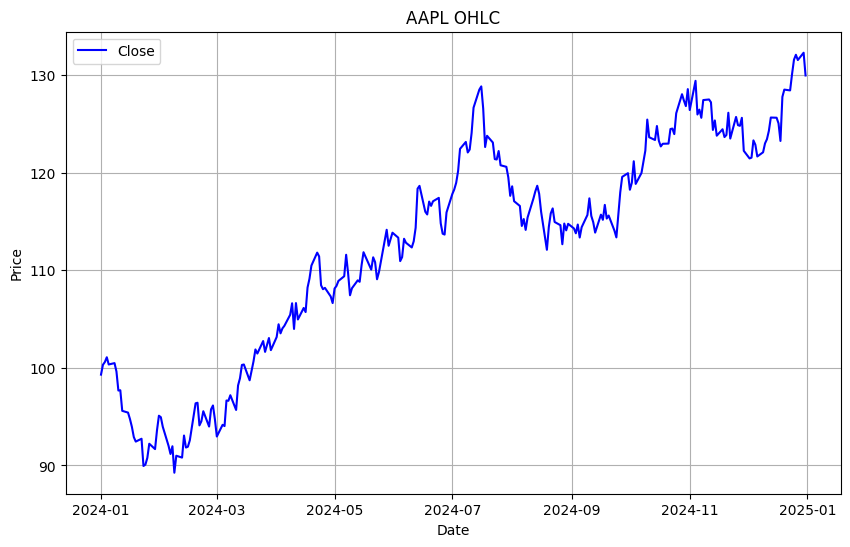

In [ ]:
# Testing the simulator
simulator = GeometricBrownianMotionAssetSimulator(
    start_date='2024-01-01',
    end_date='2024-12-31',
    output_dir='/gdrive/My Drive/BISS/EMTH0009 - Master Thesis/Data/GBM_paths',
    symbol='AAPL',
    init_price=100.0,
    mu=0.05,
    sigma=0.2
)
simulator()
import matplotlib.pyplot as plt

# Load the generated CSV file
df = pd.read_csv('/gdrive/My Drive/BISS/EMTH0009 - Master Thesis/Data/GBM_paths/AAPL.csv', parse_dates=['date'])

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(df['date'], df['close'], label='Close', color='blue')

plt.title('AAPL OHLC')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()


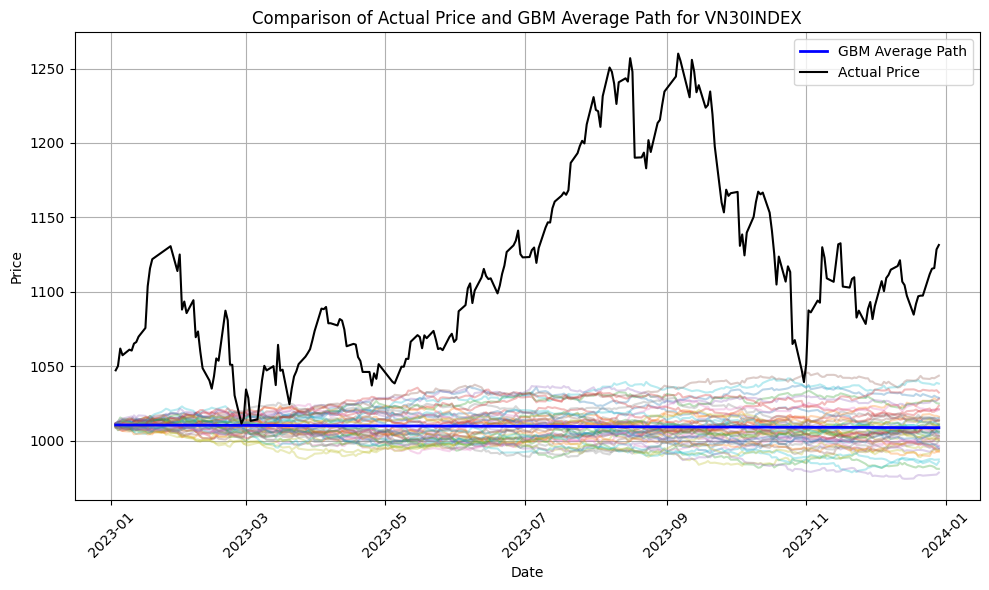

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import random

# Read the average path data
average_path_data = pd.read_csv('/gdrive/My Drive/BISS/EMTH0009 - Master Thesis/Data/GBM_paths/VN30INDEX.csv')

# Convert 'date' column to datetime format
average_path_data['date'] = pd.to_datetime(average_path_data['date'])

# Filter actual price data for ACB from hose_df_2023
actual_price_data = hose_df_2023[hose_df_2023['ticker'] == 'VN30INDEX'][['date', 'close']]

# Plot actual price and average GBM path
plt.figure(figsize=(10, 6))

# Plot randomly selected 50 GBM paths
gbm_paths = random.sample(list(average_path_data.columns[1:]), 50)
for col in gbm_paths:
    plt.plot(average_path_data['date'], average_path_data[col], alpha=0.3)

# Plot average GBM path with a bold line
plt.plot(average_path_data['date'], average_path_data['average'], label='GBM Average Path', color='blue', linewidth=2)

# Plot actual price
plt.plot(actual_price_data['date'], actual_price_data['close'], label='Actual Price', color='black')

plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Comparison of Actual Price and GBM Average Path for VN30INDEX')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()